批量处理

1. try some tokenizer

In [9]:
import pandas as pd
import re
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
def tokenize(log_content):
    words = log_content.split()
    words = [word for word in words if not re.search(r'\d', word)]
    return words


def vectorize(tokenized_logs):
    vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
    return vectorizer.fit_transform(tokenized_logs)


def cluster(vectorized_logs, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(vectorized_logs)
    return kmeans.labels_


# 读取CSV文件
dataset = 'HPC'
df = pd.read_csv(
    f'dataset/{dataset}/{dataset}_2k.log_structured_corrected.csv')

# 选择某一列，例如'column_name'
column = df['Content']

# 将该列转换为列表
column_list = column.tolist()

tokenized_logs = [tokenize(content) for content in column_list]


labels = cluster(vectorize(tokenized_logs), 51)

d:\Develop\anaconda\envs\langchain38\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\Develop\anaconda\envs\langchain38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [25]:
num = 0
for i, l in enumerate(labels):
    if l == 15:  # 12, 14 , 17, 29是异常的模板
        print(column_list[i])
        num += 1
# 75 + 45 + 30
print(num)

Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds ( 3552 3534 3375 **** 3515 3479 )
Fan speeds

显示每一批分组情况

通过三个参数选取最合适的n值

d:\Develop\anaconda\envs\langchain38\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\Develop\anaconda\envs\langchain38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Develop\anaconda\envs\langchain38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Develop\anaconda\envs\langchain38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the

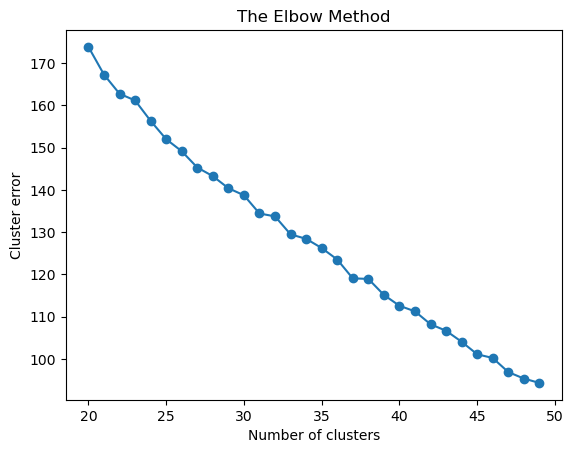

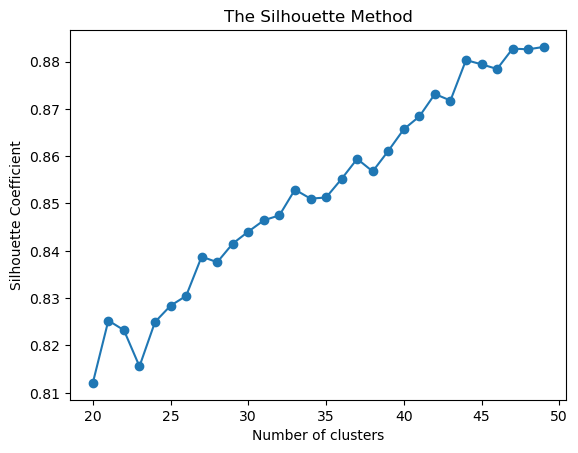

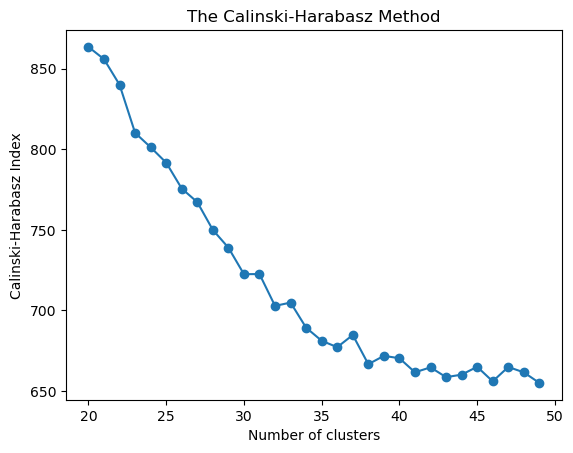

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import re

def tokenize(log_content):
    words = log_content.split()
    words = [word for word in words if not re.search(r'\d', word)]
    return words


def vectorize(tokenized_logs):
    vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
    return vectorizer.fit_transform(tokenized_logs)


def cluster(vectorized_logs, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(vectorized_logs)
    # 计算聚类误差
    cluster_error = kmeans.inertia_
    # 计算轮廓系数
    silhouette_avg = silhouette_score(vectorized_logs, kmeans.labels_)
    # 计算Calinski-Harabasz指数
    calinski_harabasz_avg = calinski_harabasz_score(vectorized_logs.toarray(), kmeans.labels_)
    return kmeans.labels_, cluster_error, silhouette_avg, calinski_harabasz_avg


# 读取CSV文件
dataset = 'OpenSSH'
df = pd.read_csv(f'dataset/{dataset}/{dataset}_2k.log_structured_corrected.csv')

# 选择某一列，例如'column_name'
column = df['Content']

# 将该列转换为列表
column_list = column.tolist()

tokenized_logs = [tokenize(content) for content in column_list]


vectorized_logs = vectorize(tokenized_logs)

range_n_clusters = range(20, 50)
# 聚类误差
errors = []

# 轮廓系数
silhouettes = []

# Calinski-Harabasz指数
calinski_harabasz_scores = []

for n_clusters in range_n_clusters:
    # 聚类
    labels, cluster_error, silhouette_avg, calinski_harabasz_avg = cluster(vectorized_logs, n_clusters)

    errors.append(cluster_error)
    silhouettes.append(silhouette_avg)
    calinski_harabasz_scores.append(calinski_harabasz_avg)

# 绘制聚类误差图
plt.figure()
plt.plot(range_n_clusters, errors, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Cluster error')
plt.title('The Elbow Method')
plt.show()

# 绘制轮廓系数图
plt.figure()
plt.plot(range_n_clusters, silhouettes, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('The Silhouette Method')
plt.show()

# 绘制Calinski-Harabasz指数图
plt.figure()
plt.plot(range_n_clusters, calinski_harabasz_scores, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('The Calinski-Harabasz Method')
plt.show()